# Bread Bot Data Processing

This is an experiment with simple visualization using Discord bot commands run on a reasonably active Discord guild. You can read the accompanying blog post [here]().

## Introduction

BreadBot, a bot running on ACM @ UCSD's Discord server, has tracked commands run with it by tracking their timestamp, author and channel location every time a command was sent. The data file was initially stored in a JSON file holding only counts, however soon afterwards, the format of the data file was changed to
a separated-values file. We will begin by extracting the data and then constructing graphs to visualize the data using interesting graphs.

## Data Import

SV file with delimiter `:` was used, with header:
`timestamp:command:username:channel`

First, we import the SV file and check for integrity of data.

In [199]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import json

sns.set()  # Import Seaborn's style, cause it's cool

commandCounts = pd.read_csv('commandCount.log', delimiter=':')
commandCounts.head(5) # Displays first 5 values from DataFrame

,timestamp,command,username,channel
0,1589948873151,cat,Storm_FireFox1#0001,🤖bot-spam
1,1589948873869,cat,Storm_FireFox1#0001,🤖bot-spam
2,1589948877293,cat,Storm_FireFox1#0001,🤖bot-spam
3,1589949285514,dog,wingdings#0001,🤖bot-spam
4,1589949287053,dog,wingdings#0001,🤖bot-spam


Before using updated format, BreadBot tracked only count of commands in a JSON file with key-value structure as `command:count`, rather than the additional information above. We'll add it to a separate DataFrame with some placeholder data in the other fields to ensure we maintain consistent data.

For reference, other placeholder values will be:
- `1589814600000`: timestamp (May 18, 2020, 8:10 PM PST, time of announcement of BreadBot count competition)
- `other#0001`: username
- `🤖bot-spam`: channel (after cursory glances, most commands were sent in #bot-spam due to guild rules, so this is sensible)

In [200]:
oldCommandCounts = pd.DataFrame(columns=['timestamp', 'command', 'username', 'channel'])

with open('commandCountOld.json', 'r') as jsonFile:
    commandCountsJson = json.load(jsonFile)
    for key, value in commandCountsJson.items():
        if value == 0: # We'll exclude commands with count 0, since the original JSON kept counts at 0, too
            continue
        for i in range(value):
            # Add this command run to the dataset value times
            oldCommandCounts = oldCommandCounts.append({'timestamp': 1589814600000, 'command': key, 'username': 'other#0001', 'channel': '🤖bot-spam'}, 
                ignore_index=True)

oldCommandCounts.head(5)

,timestamp,command,username,channel
0,1589814600000,bruh,other#0001,🤖bot-spam
1,1589814600000,bruh,other#0001,🤖bot-spam
2,1589814600000,bruh,other#0001,🤖bot-spam
3,1589814600000,bruh,other#0001,🤖bot-spam
4,1589814600000,bruh,other#0001,🤖bot-spam


"timestamp" columns from both DataFrames need to be converted to `datetime` objects for ease of use with plotting libraries.

Original function to write down timestamp (JS `Date.now()`) uses milliseconds from Unix epoch. We also convert to correct timezone for
relevant plots (UTC time not really fun for investigating localized human behaviour).

In [201]:
commandCounts['timestamp'] = pd.to_datetime(commandCounts['timestamp'], unit='ms')
oldCommandCounts['timestamp'] = pd.to_datetime(oldCommandCounts['timestamp'], unit='ms')

commandCounts['timestamp'] = commandCounts['timestamp'].dt.tz_localize('UTC').dt.tz_convert('America/Los_Angeles')
oldCommandCounts['timestamp'] = oldCommandCounts['timestamp'].dt.tz_localize('UTC').dt.tz_convert('America/Los_Angeles')

commandCounts.head(5)

,timestamp,command,username,channel
0,2020-05-19 21:27:53.151000-07:00,cat,Storm_FireFox1#0001,🤖bot-spam
1,2020-05-19 21:27:53.869000-07:00,cat,Storm_FireFox1#0001,🤖bot-spam
2,2020-05-19 21:27:57.293000-07:00,cat,Storm_FireFox1#0001,🤖bot-spam
3,2020-05-19 21:34:45.514000-07:00,dog,wingdings#0001,🤖bot-spam
4,2020-05-19 21:34:47.053000-07:00,dog,wingdings#0001,🤖bot-spam


Lastly, we'll concatenate the two DataFrames in a separate variable to have full information for simple command count analysis.

In [202]:
concatCounts = pd.concat([oldCommandCounts, commandCounts])

concatCounts.head(5)

,timestamp,command,username,channel
0,2020-05-18 08:10:00-07:00,bruh,other#0001,🤖bot-spam
1,2020-05-18 08:10:00-07:00,bruh,other#0001,🤖bot-spam
2,2020-05-18 08:10:00-07:00,bruh,other#0001,🤖bot-spam
3,2020-05-18 08:10:00-07:00,bruh,other#0001,🤖bot-spam
4,2020-05-18 08:10:00-07:00,bruh,other#0001,🤖bot-spam


## Contest Results

Initially, a competition was announced to see which command would have the most runs after two weeks. The simplest way to display these results is using a bar chart. We'll use a horizontal bar chart to list the results. Bars will represent command count, sorted in descending order.


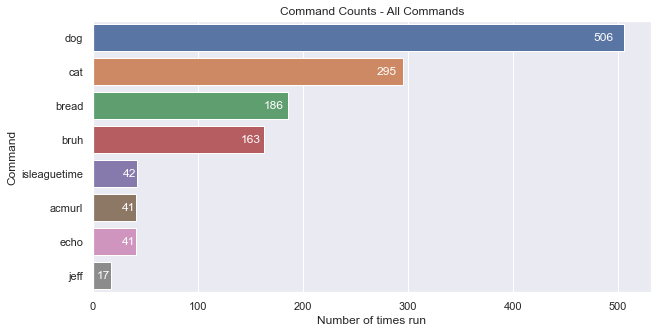

In [203]:
plt.figure(figsize=(10,5))
competitionResult = sns.countplot(y='command', data=concatCounts, order=concatCounts['command'].value_counts().index)

for p in competitionResult.patches:
    x = p.get_x() + (p.get_width() / 1.02) # move labels to the left in bar proportionally
    y = p.get_y() + (p.get_height() / 2.)  # center label on bar
    value = int(p.get_width())
    # Annotate value on x and y we calculated before
    competitionResult.text(x, y, value, ha="right", va='center', color='white')

plt.xlabel('Number of times run')
plt.ylabel('Command')
plt.title('Command Counts - All Commands')

plt.show()

## Number of commands run by user per commands

Some commands were more evenly called than others. We want to see the distribution of calls for each top command.

First, for each graph, we'll filter command and aggregate by member. Then, we simply bar plot the counts into separate figures for each command.
Since subplots make all the plots look really bad (too low resolution), separate figures are plotted and then saved to files. We'll display an
example figure that comes out of this plot below.

In [204]:
for command in commandCounts['command'].unique():
    fig = plt.figure(dpi=300)

    filteredCommandCounts = commandCounts.query("command == '" + command + "'")
    numberOfUserCallsOfCommand = sns.countplot(y='username', data=filteredCommandCounts, order=filteredCommandCounts['username'].value_counts().index)

    for p in numberOfUserCallsOfCommand.patches:
        x = p.get_x() + (p.get_width() / 1.02)   # move labels to the left in bar proportionally
        y = p.get_y() + (p.get_height() / 1.75)  # center label on bar
        value = int(p.get_width())
        if value == 1:
            # We don't want to annotate any bar with value "1", since
            # most charts end up being really small.
            continue
        numberOfUserCallsOfCommand.text(x, y, value, ha="right", va='center', color='white')
    plt.xlabel('Number of times run')
    plt.ylabel('Username')
    plt.title('Command Call Distribution by User - /' + command)
    plt.savefig('outputs/commandDistribution-' + command + '.png', bbox_inches='tight')
    plt.savefig('outputs/commandDistribution-' + command + '.svg', bbox_inches='tight')
    plt.close(fig)

![Plot for /bread](outputs/commandDistribution-bread.svg)

## Peak times for commands

Members of ACM are more active on Discord at different times from one another. Sadly, tracking the number of commands is not perfectly geniune
to activity on the server (not all users use BreadBot's commands often), but we'll try this for now. We'll do full message data later.

Firstly, we'll take the existing dataset and split the timestamp column into day of week and hour of day.
This will let us plot a heatmap of the schedule over a weekly schedule.

In [205]:
commandCounts['Weekday'] = commandCounts['timestamp'].dt.strftime('%A') # full weekday
commandCounts['hour'] = commandCounts['timestamp'].dt.strftime('%-I %p')  # example: 12 AM
commandCounts.head(5)

,timestamp,command,username,channel,Weekday,hour
0,2020-05-19 21:27:53.151000-07:00,cat,Storm_FireFox1#0001,🤖bot-spam,Tuesday,9 PM
1,2020-05-19 21:27:53.869000-07:00,cat,Storm_FireFox1#0001,🤖bot-spam,Tuesday,9 PM
2,2020-05-19 21:27:57.293000-07:00,cat,Storm_FireFox1#0001,🤖bot-spam,Tuesday,9 PM
3,2020-05-19 21:34:45.514000-07:00,dog,wingdings#0001,🤖bot-spam,Tuesday,9 PM
4,2020-05-19 21:34:47.053000-07:00,dog,wingdings#0001,🤖bot-spam,Tuesday,9 PM


Next, we generate the heatmap. We want it to look like a calendar, so it's intuitive. We'll list weekdays horizontally, and times vertically.

We'll set up the pivot table accordingly and Seaborn will do the rest. (Yay!)

In [206]:
# We need these because Pandas sorts the index alphabetically, but that's not the same
# as actual chronological order. We use these sample lists to sort the index and columns
# properly.
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hours = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM',
         '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM']

commandTimes = pd.crosstab(commandCounts['hour'], commandCounts['Weekday'])
[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
commandTimes = commandTimes.reindex(days, axis="columns") # sort days
commandTimes = commandTimes.reindex(hours, axis="rows", fill_value = 0) # sort hours

commandTimes

Weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
hour,,,,,,,
12 AM,10,2,57,43,11,15,53
1 AM,1,1,0,2,1,7,4
2 AM,0,0,1,0,0,18,0
3 AM,0,7,0,0,0,0,5
4 AM,0,0,0,0,0,0,1
5 AM,0,0,0,0,0,0,0
6 AM,0,0,0,0,0,0,0
7 AM,0,0,0,0,0,0,0
8 AM,0,0,0,0,0,0,0


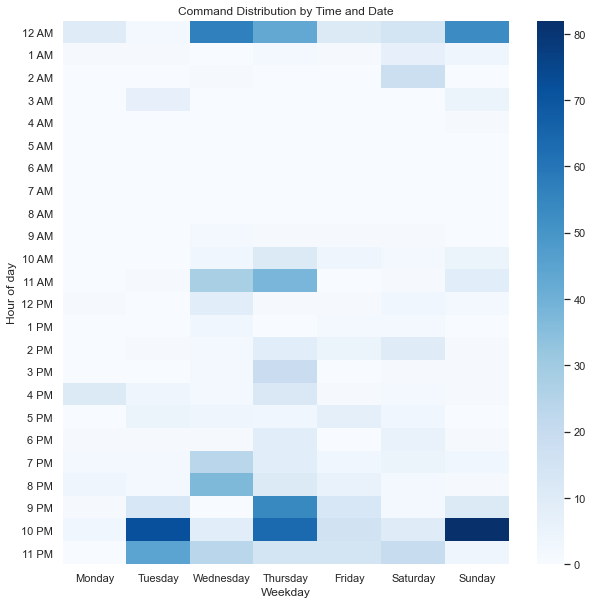

In [207]:
plt.figure(figsize=(10,10))

ax = sns.heatmap(commandTimes, cmap='Blues')
plt.xlabel('Weekday')
plt.ylabel('Hour of day')
plt.title('Command Distribution by Time and Date')

plt.show()

## Peak chat times using DiscordChatExporter

Since not everyone uses BreadBot commands as much as others (data points to biases of singular members abusing specific commands),
we'll attempt the same heatmap using more relevant data.

We can use Discord Chat Exporter to extract messages across all channels of a guild. After doing so, we may import the values
into the notebook and run the same procedure as for the previous heatmap, except using full message data.

To run DiscordChatExporter and extract all messages from the channels of a guild, I used the following command (assume environment variables are set according to [DiscordChatExporter wiki](https://github.com/Tyrrrz/DiscordChatExporter/wiki/Docker-usage-instructions) or manually):

```bash
docker run --rm -it -v $PWD:/app/out tyrrrz/discordchatexporter:stable exportguild -g $GUILD_ID --dateformat "u" -t $DISCORD_TOKEN -f Csv
```

Once all chats are successfuly exported, we can firstly concatenate all of the messages at first (we're not interested in anything else but times
of messages), and begin santizing for the heatmap, similarly to what we did with the command data frame.

In [208]:
import glob

discordChatLogs = glob.glob(os.path.join(".", "discordChats", "*.csv")) # Get list of all files with ".csv" at the end

chatMessages = pd.concat((pd.read_csv(log) for log in discordChatLogs)) # Read each file
chatMessages.head(5)

,AuthorID,Author,Date,Content,Attachments,Reactions
0,334441828512432129,Hairy Otter#4797,2020-05-26 00:11:10Z,first,NaN,NaN
1,184400560634593281,Storm_FireFox1#0001,2020-05-26 00:11:26Z,You mean zeroth,NaN,NaN
2,184400560634593281,Storm_FireFox1#0001,2020-05-26 00:11:31Z,Use correct indexing,NaN,NaN
3,334441828512432129,Hairy Otter#4797,2020-05-26 00:11:31Z,you right,NaN,NaN
4,334441828512432129,Hairy Otter#4797,2020-05-26 00:12:07Z,Good Omens is a pretty nice book. Also has its...,NaN,NaN


In [209]:
chatMessages['Date'] = pd.to_datetime(chatMessages['Date'], utc=True).dt.tz_convert('America/Los_Angeles')
chatMessages.head(5)

,AuthorID,Author,Date,Content,Attachments,Reactions
0,334441828512432129,Hairy Otter#4797,2020-05-25 17:11:10-07:00,first,NaN,NaN
1,184400560634593281,Storm_FireFox1#0001,2020-05-25 17:11:26-07:00,You mean zeroth,NaN,NaN
2,184400560634593281,Storm_FireFox1#0001,2020-05-25 17:11:31-07:00,Use correct indexing,NaN,NaN
3,334441828512432129,Hairy Otter#4797,2020-05-25 17:11:31-07:00,you right,NaN,NaN
4,334441828512432129,Hairy Otter#4797,2020-05-25 17:12:07-07:00,Good Omens is a pretty nice book. Also has its...,NaN,NaN


In [210]:
chatMessages['Weekday'] = chatMessages['Date'].dt.strftime('%A') # full weekday
chatMessages['Hour'] = chatMessages['Date'].dt.strftime('%-I %p')  # example: 12 AM
chatMessages.head(5)

,AuthorID,Author,Date,Content,Attachments,Reactions,Weekday,Hour
0,334441828512432129,Hairy Otter#4797,2020-05-25 17:11:10-07:00,first,NaN,NaN,Monday,5 PM
1,184400560634593281,Storm_FireFox1#0001,2020-05-25 17:11:26-07:00,You mean zeroth,NaN,NaN,Monday,5 PM
2,184400560634593281,Storm_FireFox1#0001,2020-05-25 17:11:31-07:00,Use correct indexing,NaN,NaN,Monday,5 PM
3,334441828512432129,Hairy Otter#4797,2020-05-25 17:11:31-07:00,you right,NaN,NaN,Monday,5 PM
4,334441828512432129,Hairy Otter#4797,2020-05-25 17:12:07-07:00,Good Omens is a pretty nice book. Also has its...,NaN,NaN,Monday,5 PM


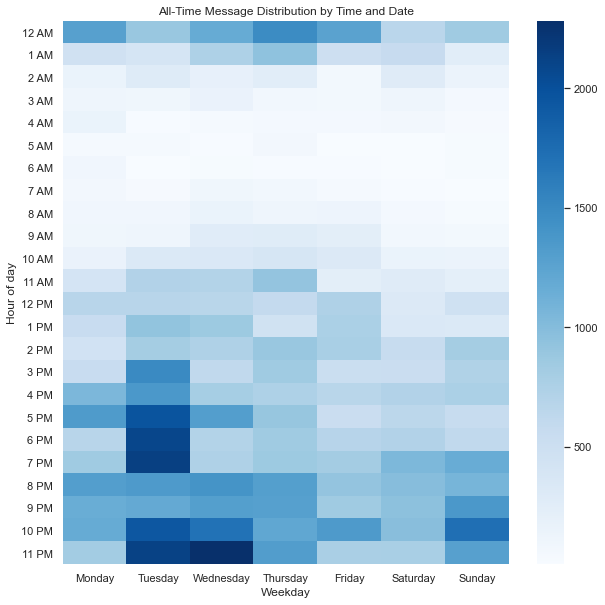

In [211]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hours = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM',
         '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM']

messageTimes = pd.crosstab(chatMessages['Hour'], chatMessages['Weekday'])
messageTimes = messageTimes.reindex(days, axis="columns")
messageTimes = messageTimes.reindex(hours, axis="rows", fill_value = 0)

plt.figure(figsize=(10,10))

sns.heatmap(messageTimes, cmap='Blues')
plt.xlabel('Weekday')
plt.ylabel('Hour of day')
plt.title('All-Time Message Distribution by Time and Date')

plt.show()

These heatmaps can also be refined to only include specific users' messages by merely querying for the users. Below we have an example of the same graph, but for myself. You can try different users from the guild by changing the `author` variable.

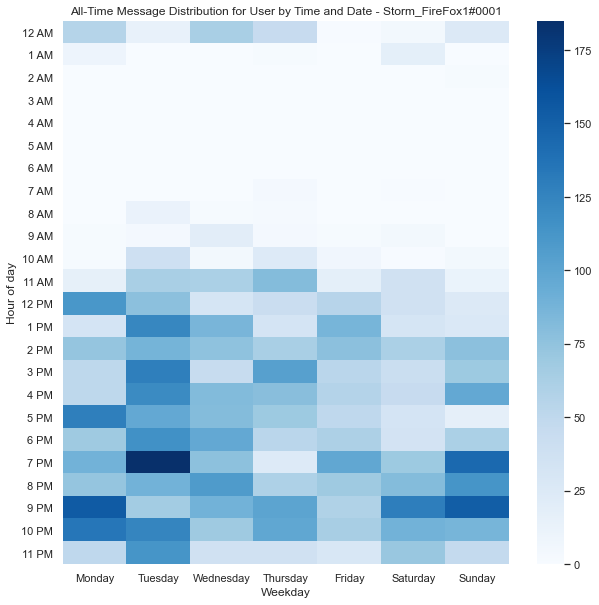

In [212]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hours = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM',
         '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM']
author = 'Storm_FireFox1#0001' # Change this. You probably want to put in username and tag

queriedMessages = chatMessages.query(f"Author == '{author}'") # Filter out any message not by author

userMessageTimes = pd.crosstab(queriedMessages['Hour'], queriedMessages['Weekday'])
userMessageTimes = userMessageTimes.reindex(days, axis="columns")
userMessageTimes = userMessageTimes.reindex(hours, axis="rows", fill_value = 0)

plt.figure(figsize=(10,10))

sns.heatmap(userMessageTimes, cmap='Blues')
plt.xlabel('Weekday')
plt.ylabel('Hour of day')
plt.title('All-Time Message Distribution for User by Time and Date - ' + author)

plt.show()

Note the spike in the all-time distribution at around 11 PM. We will investigate by looking at the data directly.

## 11 PM Spike

I think looking at the most common words to appear during that time in messages will shed light on the spike mystery.

We begin by filtering all messages to only look at those on wednesdays at 11 PM.

In [213]:
spikeMessages = chatMessages.query("Weekday == 'Wednesday' and Hour == '11 PM'")
spikeMessages.head(5)

,AuthorID,Author,Date,Content,Attachments,Reactions,Weekday,Hour
17,90669319024836608,for loop#9853,2019-05-29 23:03:31-07:00,@Daniel Truong are you a branch?,NaN,NaN,Wednesday,11 PM
18,90669319024836608,for loop#9853,2019-05-29 23:04:25-07:00,Bc I wanna git outta here and check you out 🤨,NaN,😮 (1),Wednesday,11 PM
429,148981420042223616,rin#0388,2019-08-14 23:23:15-07:00,computer science is PrObLeM SoLvLnG,NaN,NaN,Wednesday,11 PM
978,90669319024836608,for loop#9853,2019-12-25 23:51:42-08:00,NaN,https://cdn.discordapp.com/attachments/5730319...,🥴 (2),Wednesday,11 PM
1019,550159084020563969,Emily Chin#5096,2020-01-08 23:24:38-08:00,Big :oof:. Copied from Eldridge's DSC 10 HW #1...,https://cdn.discordapp.com/attachments/5730319...,NaN,Wednesday,11 PM


We'll continue by grouping the messages by date. This will at least give us a view of what was the longest conversation during that time.

In [214]:
spikeMessages['daydate'] = spikeMessages['Date'].dt.strftime("%d-%m-%Y")
spikeMessages['daydate'].value_counts()

27-05-2020    796
06-05-2020    332
15-04-2020    275
03-06-2020    248
20-05-2020    171
13-05-2020    107
10-06-2020     74
08-01-2020     59
01-04-2020     40
08-04-2020     23
09-10-2019     21
22-04-2020     19
25-03-2020     10
18-12-2019     10
18-03-2020      9
15-01-2020      8
25-09-2019      8
29-01-2020      8
12-02-2020      7
04-12-2019      6
29-04-2020      6
28-08-2019      6
04-03-2020      6
11-12-2019      6
11-09-2019      5
06-11-2019      5
11-03-2020      3
16-10-2019      2
29-05-2019      2
22-01-2020      2
20-11-2019      1
01-01-2020      1
14-08-2019      1
30-10-2019      1
05-02-2020      1
05-06-2019      1
25-12-2019      1
07-08-2019      1
Name: daydate, dtype: int64

Looking at the data directly, we notice a very specific conversation taking place on the provided date, which was internal to board. I will exclude details about the conversation at this time.

In [215]:
spikeMessages = spikeMessages.query("daydate == '27-05-2020'")
spikeMessages.head(5)

,AuthorID,Author,Date,Content,Attachments,Reactions,Weekday,Hour,daydate
259,262163646132649985,hexalellogram#1647,2020-05-27 23:13:09-07:00,https://www.facebook.com/donate/17534963055909...,NaN,NaN,Wednesday,11 PM,27-05-2020
260,262163646132649985,hexalellogram#1647,2020-05-27 23:14:16-07:00,"@truly : ""ucla is raising money by giving thei...",NaN,NaN,Wednesday,11 PM,27-05-2020
261,261357590829596674,truly#5810,2020-05-27 23:14:27-07:00,exactly,NaN,NaN,Wednesday,11 PM,27-05-2020
262,261357590829596674,truly#5810,2020-05-27 23:14:45-07:00,we should auction off our vp's hair(cut),NaN,NaN,Wednesday,11 PM,27-05-2020
263,261357590829596674,truly#5810,2020-05-27 23:14:47-07:00,i volunteer bryce,NaN,NaN,Wednesday,11 PM,27-05-2020


## Member Growth

We'll also look at how the Discord server has grown over time by looking at amount of messages by month. (i.e. amount of activity by month)

Afterwards, we create a simple bar plot. We'll exclude June, since the month is not over yet. (as of time of writing and extraction of dataset)
Additionally, we'll disable sorting, as this messes up the sorting of the dates we've done before (alphabetical sort != chronological order)

In [216]:
chatMessages['month'] = chatMessages['Date'].dt.strftime('%b %Y')
chatMessages = chatMessages.sort_values(by='Date')
countByMonth = chatMessages['month'].value_counts().reindex(chatMessages['month'].unique())

countByMonth

May 2019      322
Jun 2019      779
Jul 2019     1157
Aug 2019     2071
Sep 2019     3592
Oct 2019     4415
Nov 2019     2655
Dec 2019     1906
Jan 2020     5649
Feb 2020     2391
Mar 2020     4768
Apr 2020    17840
May 2020    43153
Jun 2020    13554
Name: month, dtype: int64

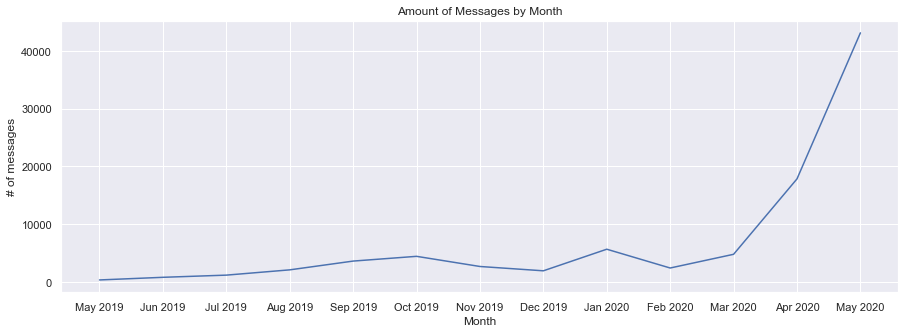

In [217]:
plt.figure(figsize=(15,5))

sns.lineplot(data=countByMonth.drop('Jun 2020'), sort=False)
plt.title('Amount of Messages by Month')
plt.xlabel('Month')
plt.ylabel('# of messages')
plt.show()